In [1]:
# import things
import KenGP as gp
import numpy as np
import pandas as pd
import numpy.linalg as la
import numpy.random as rand
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider, Button, RadioButtons

%load_ext autoreload
%autoreload 2


In [2]:
"""
# These are our constants
N = 5  # Number of variables
F = 8  # Forcing


def L96(x, t):
    #Lorenz 96 model with constant forcing
    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d


x0 = F * np.ones(N)  # Initial state (equilibrium)
x0[0] += 0.01  # Add small perturbation to the first variable
t = np.arange(0.0, 30.0, 0.01)

x = odeint(L96, x0, t)

# Plot the first three variables
fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(x[:, 0], x[:, 1], x[:, 2])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_3$")
plt.show()
"""

'\n# These are our constants\nN = 5  # Number of variables\nF = 8  # Forcing\n\n\ndef L96(x, t):\n    #Lorenz 96 model with constant forcing\n    # Setting up vector\n    d = np.zeros(N)\n    # Loops over indices (with operations and Python underflow indexing handling edge cases)\n    for i in range(N):\n        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F\n    return d\n\n\nx0 = F * np.ones(N)  # Initial state (equilibrium)\nx0[0] += 0.01  # Add small perturbation to the first variable\nt = np.arange(0.0, 30.0, 0.01)\n\nx = odeint(L96, x0, t)\n\n# Plot the first three variables\nfig = plt.figure()\nax = fig.gca(projection="3d")\nax.plot(x[:, 0], x[:, 1], x[:, 2])\nax.set_xlabel("$x_1$")\nax.set_ylabel("$x_2$")\nax.set_zlabel("$x_3$")\nplt.show()\n'

In [3]:
# Rossler System
def Rossler(xi, t):
    a = 0.2
    b = 0.2
    c = 5.7
    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def RosslerP(xi, t, a, b, c):    
    (x,y,z) = xi

    dx = -y - z
    dy = x + a * y
    dz = b + z * ( x - c )

    return np.array( [dx,dy,dz] )

def Lorenz(xi,t):
    rho = 25.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def LorenzP(xi,t, rho, sigma, beta):
    
    (x,y,z) = xi
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

def Lorenz96(x, t):
    N = 5 # dimension
    F = 8

    # Setting up vector
    d = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        d[i] = (x[(i + 1) % N] - x[i - 2]) * x[i - 1] - x[i] + F
    return d    

def LorenzYang(xi, t):
    k1 = lambda t : -0.01*(t**2)
    k2 = lambda t : 0.01*t
    k3 = lambda t : 0.01*t
    k4 = lambda t : -0.01*(t ** 2)

    rho = 28.0
    sigma = 10.0
    beta = 8.0 / 3.0
    
    (x,y,z) = xi
    return -sigma*(x-y)+k1(t)*y, rho*x-y-x*z+k2(t)*z, -beta*z+x*y+(k3(t)+k4(t))*y  # Derivatives

def Sprott(xi, t):
    (x,y,z) = xi
    return ( y, -x - np.sign(z)*y, y**2 - np.exp(-x**2))

def SprottP(xi, t, d):
    (x,y,z) = xi
    return ( y/d, -x - d*np.sign(z)*y, y**2 - d*np.exp(-x**2))

In [4]:
def delayEmbed(Xin, Yin,assignment,embInterval):
    
    tmplen = Xin.shape[1]

    tmp = np.zeros([sum(x) for x in zip(Xin.shape,(0,sum(assignment)))])
    tmp[:,:Xin.shape[1]] = Xin
    Xin = tmp

    lag = 1
    newColInd = 0
    if len(assignment) != tmplen:
        print("Assigment list doesn't match the number of variables in data array! ",assignment)
        return
    else:
        # code that creates the lags
        for i in range(len(assignment)):
            lag = 1
            for _ in range(assignment[i]):
                newCol = Xin[:-embInterval*lag,i]
                Xin[embInterval*lag:, tmplen + newColInd] = newCol
                newColInd += 1
                lag += 1
    Xin = Xin[embInterval*sum(assignment):]
    Yin = Yin[embInterval*sum(assignment):]
    
    # Yin = Yin[-X.shape[0]:]
    
    return (Xin, Yin)

def standardize(x):
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def nearestNeighbors(s0, S, n):
    orderedNeighbors = np.argsort(la.norm(s0 - S[:-1],axis=1))
    return orderedNeighbors[1:n+1]

# Lyapunov Edition
def lyapunovExp(S):
    Lexp = 0
    n = S.shape[0]-1
    for i in range(n):
        nearNeighborsIndices = nearestNeighbors(S[i], S, 1)
        for nni in nearNeighborsIndices:
            fprime = la.norm(S[i+1] - S[nni+1]) / la.norm(S[i] - S[nni])
            Lexp += np.log(fprime) # / la.norm(S[i] - S[nni])
    return Lexp / n # geometric mean - seems like lyapunov right?


In [175]:
settlingTime = 5

end = 2**7
tlen = 2 ** 8 + settlingTime
trainToTest = 0.8 # between 0 and 1
t = np.linspace(0, end, num=tlen)

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 2
ndrivers = 1
# t0 = np.array([0.5])
t0 = np.ones(dim) * 0.3333# np.array([0,5,15])# np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
t0[0] += 0.1

In [329]:
# Discrete Time Systems
"""
# Munch Model, includes a time lag explicitly
trueLag = 4
initval = 2
r = 1.75 # vals used are 8, 3.5, 2.5, 1.75
states = np.zeros((tlen,1))
for i in range(tlen):
    if i <= trueLag:
        states[i] = initval
    else: 
        states[i] = r*states[i-1]*np.exp(-states[i-1-trueLag]+rand.normal(0,0.1,1))

"""

# Logistic Map
"""
r = lambda t : 0.25 * np.sin(t/30) + 3.75
states = np.zeros((tlen,1))
states[0,0] = t0
for t in range(1,tlen):
    states[t,0] = r(t) * states[t-1,0] * (1 - states[t-1,0])
""" 

# Density Dependent Maturation

states = np.ones((tlen, 2))
s = 0.02
gamma = 0.01
sA = 0.1
sJ = 0.5
b = 35
# Gmax = 0.9
# g = lambda x : Gmax*np.exp(-gamma*x)
Gmax = lambda t : 0.25 + t * 0.74 / (tlen-2)
g = lambda x , t: Gmax(t)*np.exp(-gamma*x)
states[0] = np.array([5,300])
for i in range(0,tlen-1):
    At = states[i,0]
    Jt = states[i,1]
    zt = rand.normal(-s/2, s) # rand.normal(0,s) # vs rand.normal(-(s**2)/2, s)
    # m = np.array([[sA, sJ*g(At+Jt)],[b*np.exp(zt), sJ*(1-g(At+Jt))]])
    m = np.array([[sA, sJ*g(At+Jt,i)],[b*np.exp(zt), sJ*(1-g(At+Jt,i))]])
    states[i+1] = m @ states[i].T

Xr = standardize(states[settlingTime:,:])


In [330]:

# STATIONARY SIMULATION VERSION: UPDATE ATTRACTOR YOU WANT HERE
#               \/\/\/\/
"""
t0 = np.array([4,12,17])
states = odeint(Lorenz,t0,t)
# print(states)
# print(states)
# END STATIONARY SIMULATION
"""

# FROM DATA
"""
file = "paramecium_didinium - cleaned.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
states = data.to_numpy()
print(states)
"""
# END FROM DATA


# NON STATIONARY VERSION
"""
rho = 28        # rho = 28.0
sigma = 10       # sigma = 10.0
beta = 8.0 / 3.0  # beta = 8.0 / 3.0

deltaP = 1
states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    states[i] = odeint(LorenzP,states[i-1],np.array([0,step]),args=(rho,sigma,beta))[1,:]
    sigma += deltaP
"""
"""
k1 = lambda t : -0.01*(t**2)
k2 = lambda t : 0.01*t
states = odeint(LorenzYang, t0, t)
Xr = standardize(states[settlingTime:])
"""

"""
# Sprott 
driverArray = standardize(odeint(Sprott,np.array([0.8,0.8,0.3]),np.linspace(0,2**2,num=tlen))[:,0])
driverArray = 2 * driverArray / np.ptp(driverArray)
# dp = lambda t : 0.5 + 0.35 * np.cos(0.9 *2*np.pi*t/tlen)# 0.5 * t / tlen
# dp = lambda t : 0.25
dp = lambda t : 0.75 + 0.5 * np.take(driverArray,t)

largs = lambda t : (dp(t),)

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(SprottP,states[i-1],t[i-1:i+1],args=largs(i))[1,:]
Xr = standardize(states[settlingTime:])

# Xr = standardize(odeint(Sprott,t0,t))
"""
"""
# Lorenz
driverArray = standardize(odeint(Sprott,np.array([0.8,0.8,0.3]),np.linspace(0,2**2,num=tlen))[:,0])
driverArray = 2 * driverArray / np.ptp(driverArray)

rho = lambda t : 28 # + 2* (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) #np.sin(np.sqrt(2)/3*2*np.pi*t/tlen) + 4*np.sin(1.687/7*2*np.pi*t/tlen)  # rho = 28.0
# sigma = 10       # sigma = 10.0
sigma = lambda t : 8.5 + 2.5*np.take(driverArray,t)# + np.cos(1/2*2*np.pi * t / (tlen-2))
beta = lambda t : 8.0 / 3.0  # beta = 8.0 / 3.0

largs = lambda t : (rho(t), sigma(t), beta(t))

states = np.zeros((tlen,3))
states[0] = t0
for i in range(1, tlen ):
    # print(largs(i))
    states[i] = odeint(LorenzP,states[i-1],np.array([t[i-1],t[i]]),args=largs(i))[1,:]
# Xr = standardize(states[:,1,None])
Xr = standardize(states)
"""
# END NON STATIONARY


'\n# Lorenz\ndriverArray = standardize(odeint(Sprott,np.array([0.8,0.8,0.3]),np.linspace(0,2**2,num=tlen))[:,0])\ndriverArray = 2 * driverArray / np.ptp(driverArray)\n\nrho = lambda t : 28 # + 2* (2*np.heaviside(t-500, 1)-np.heaviside(t-1000, 1)) #np.sin(np.sqrt(2)/3*2*np.pi*t/tlen) + 4*np.sin(1.687/7*2*np.pi*t/tlen)  # rho = 28.0\n# sigma = 10       # sigma = 10.0\nsigma = lambda t : 8.5 + 2.5*np.take(driverArray,t)# + np.cos(1/2*2*np.pi * t / (tlen-2))\nbeta = lambda t : 8.0 / 3.0  # beta = 8.0 / 3.0\n\nlargs = lambda t : (rho(t), sigma(t), beta(t))\n\nstates = np.zeros((tlen,3))\nstates[0] = t0\nfor i in range(1, tlen ):\n    # print(largs(i))\n    states[i] = odeint(LorenzP,states[i-1],np.array([t[i-1],t[i]]),args=largs(i))[1,:]\n# Xr = standardize(states[:,1,None])\nXr = standardize(states)\n'

In [331]:
""" UPDATE DRIVERS HERE """

digiDrivers = [Gmax]

"""
gtsr = np.zeros((Xr.shape[0], ndrivers))
for ind in range(len(digiDrivers)):
    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax
    gtsr[:,ind] = tmp
"""
gtsr = Gmax(t) # driverArray

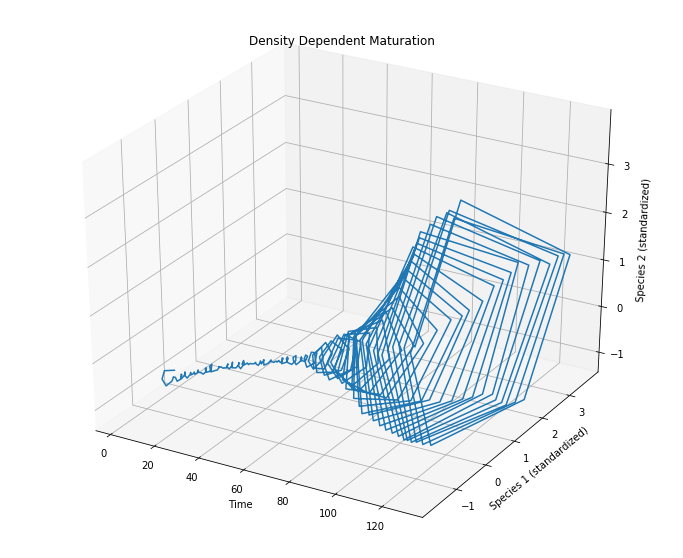

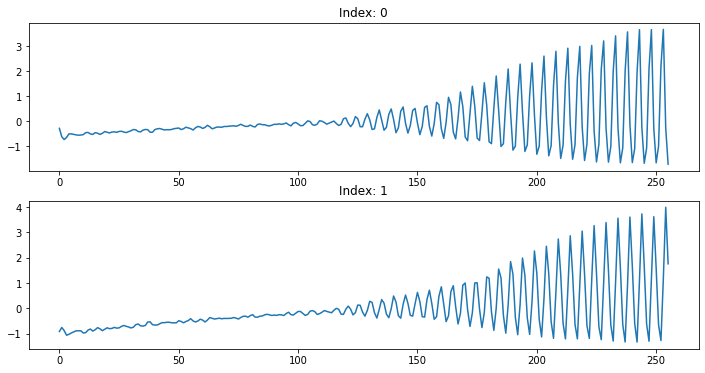

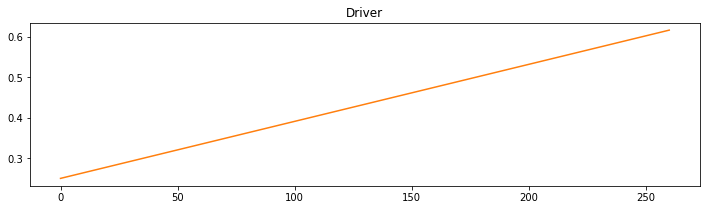

In [332]:
fig2 = plt.figure(2,figsize=(12,10))
"""
if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2])
""" 
ax2 = fig2.gca(projection="3d")
ax2.plot(t[settlingTime:],Xr[:,0],Xr[:,1])
ax2.set_xlabel("Time")
ax2.set_ylabel("Species 1 (standardized)")
ax2.set_zlabel("Species 2 (standardized)")

ax2.set_title("Density Dependent Maturation")
plt.savefig("Raw Data")

if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(12,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])

plt.savefig("Individual Dimensions")
        
if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(12,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver")
        axD.plot(gtsr, c="tab:orange")
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
            
    plt.savefig("Drivers")
        
plt.show()

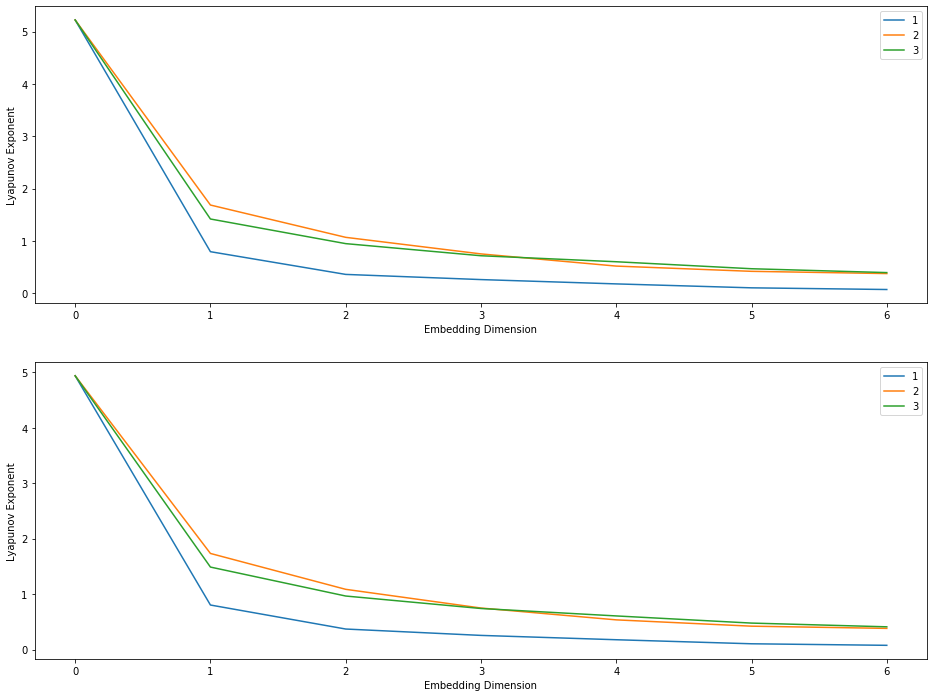

In [316]:
# False Nearest Neighbors Test

# Unitary Embedding Testing

l = 6
st = 3

# figFNN, axFNN = plt.subplots(2 * c,figsize=(16, 3*(2*c)))
figFNN, axFNN = plt.subplots(dim, figsize=(16, 6*dim))
# figFNN = plt.figure(figsize=(12, 8))
# axFNN = figFNN.add_subplot()

for d in range(dim):
    lyapExps = np.zeros(l+1)
    for s in range(1, st+1, 1):
        for i in range(l+1):
            Y, _ = delayEmbed(Xr[:,d,None], Xr[:,d,None], [i],s) # individual axis version
            # Y, _ = delayEmbed(Xr[::c], Xr[::c], [i]*dim,s)
            # Y, _ = delayEmbedUnitary(Xr[::c], Xr[::c], i,s)
            lyapExps[i] = lyapunovExp(Y)
            
        if dim == 1:
            axFNN.plot(range(l+1), lyapExps, label="{e}".format(e=s))
        else:
            axFNN[d].plot(range(l+1), lyapExps, label="{e}".format(e=s))

    if dim == 1:
        axFNN.legend()
        axFNN.set_xlabel("Embedding Dimension")
        # axFNN[c-1].set_title("Slice = {ind}".format(ind=c))
        axFNN.set_ylabel("Lyapunov Exponent")
    else:
        axFNN[d].legend()
        axFNN[d].set_xlabel("Embedding Dimension")
        # axFNN[c-1].set_title("Slice = {ind}".format(ind=c))
        axFNN[d].set_ylabel("Lyapunov Exponent")
    
plt.show()

In [317]:
# Normalize, split data
# states = (states - states.mean(0) ) / states.std(0) # normalize
# testTrainSplit = int(states.shape[0] * trainToTest)
testTrainSplit = int(Xr.shape[0] * trainToTest)

# X = states[:-1]
# Y = states[1:,]

predictionStepSize = 2

Xp = Xr[:-predictionStepSize]
Yp = Xr[predictionStepSize:,]
    
# Xt = np.column_stack((X[testTrainSplit:,], X[testTrainSplit-1:-1,1]))
X = Xp[:testTrainSplit,]
Y = Yp[:testTrainSplit,]


In [318]:
# # # GP SETUP # # #
gp.setCovar("sqrexpf")
gp.setPrior(1,"half-normal")
gp.setPrior(2,"half-normal")
gp.setPrior(3,"exponential")
gp.setData(X,Y)
gp.setTimeDelayInterval(1)

assignment = [0,0]
gp.setTimeDelayEmbedding(assignment)
# print(gp.X)
numparams = 4
for i in range(numparams,numparams+sum(assignment)):
    gp.setPrior(i,"ARD")
embDim = sum(assignment)


#print(type(X),type(Y),type(assignment))


Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential'}
Covariance function set to  sqrexpf
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential'}
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential'}
Data input success
Prior dict  {0: 'none', 1: 'half-normal', 2: 'half-normal', 3: 'exponential'}


In [319]:
# setup training data
Xt = Xp[testTrainSplit:,]
Yt = Yp[testTrainSplit:,]
Xt, Yt = delayEmbed(Xt,Yt,assignment,1)

print(Xt.shape, Yt.shape)

(50, 2) (50, 2)


Gradient:  [-0.777  -0.503  -0.1742 -0.336 ]
Likelihood:  29.02494395771024
Hp:  [0.45 0.45 0.45 0.45]  #  1
Gradient:  [-0.7697 -0.4834 -0.1802 -0.376 ]
Likelihood:  44.23007682839151
Hp:  [0.39 0.39 0.39 0.39]  #  2
Gradient:  [-0.7605 -0.4458 -0.1837 -0.435 ]
Likelihood:  64.34518193983631
Hp:  [0.318 0.318 0.318 0.318]  #  3
Gradient:  [-0.7469 -0.361  -0.1744 -0.5305]
Likelihood:  91.52034148810192
Hp:  [0.2316 0.2316 0.2316 0.2316]  #  4
Gradient:  [-0.6943 -0.0919 -0.0885 -0.7083]
Likelihood:  127.784415365384
Hp:  [0.1279 0.1279 0.1279 0.1279]  #  5
Gradient:  [ 0.053   0.8105  0.3922 -0.4317]
Likelihood:  148.87646088774724
Hp:  [0.1798 0.1798 0.1798 0.0035]  #  6
Gradient:  [-0.1569  0.363  -0.0371 -0.9178]
Likelihood:  205.00810554243574
Hp:  [0.1538 0.242  0.1538 0.    ]  #  7
Gradient:  [0.0505 0.0336 0.0199 0.998 ]
Likelihood:  206.23366247882785
Hp:  [0.1668 0.3166 0.1668 0.0746]  #  8
Gradient:  [-0.269  -0.1046 -0.0733 -0.9546]
Likelihood:  174.94756784568838
Hp:  [0.1

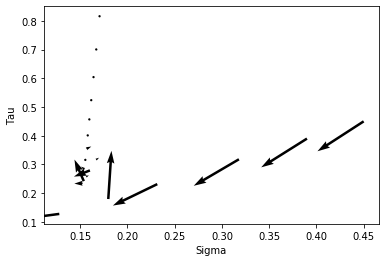

In [320]:
# optimize them parameters

gp.hyperParamOptimize(steps=20, yind=0) # <<<< THIS IS EXPENSIVE

In [321]:
# gp.setHP([0.1349,0.9134,0.1995,0.007, 1.,0.5832,0.3325,0.1837,0.5832,0.1165])

In [322]:
print(Yt.shape, Xt.shape)

(50, 2) (50, 2)


In [323]:
np.set_printoptions(precision=4,suppress=True)
print(gp.hp)

# One step predictions
predictions = np.zeros((len(Xt),dim))
variances = np.zeros((len(Xt),1))
for i in range(len(Xt)):
    predTuple = gp.predict(Xt[i])
    predictions[i] = predTuple[0] # list of one step prediction values for graphing
    variances[i] = predTuple[1]
    
diffTable = la.norm(Yt - predictions,axis=1)
# print("Predictions ", predictions)
# print("DiffTable ", diffTable)


[0.1705 0.8158 0.1623 0.    ]


In [324]:
# feed forward prediction

print(Xt.shape)

n = Xt.shape[0] # num steps
feedForwardPrediction = np.zeros(Xt.shape)
feedForwardPrediction[0,] = Xt[0]
for i in range(n-1):
    feedForwardPrediction[i+1] = gp.predict(feedForwardPrediction[i])[0]


(50, 2)


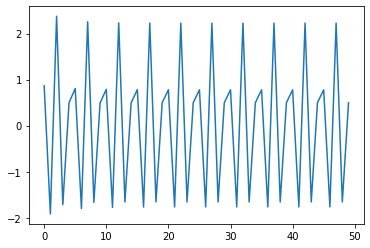

In [325]:
figA, axA = plt.subplots(1)
axA.plot(feedForwardPrediction[:,0])
plt.show()

Mean Squared Error:  0.10735822725602309


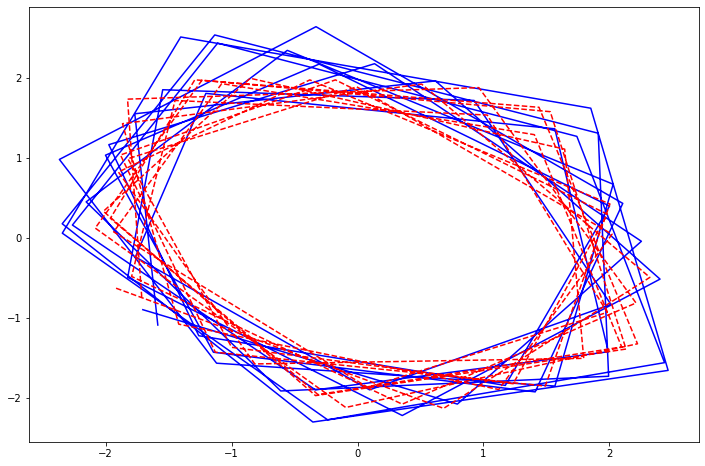

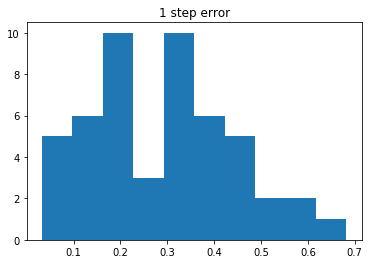

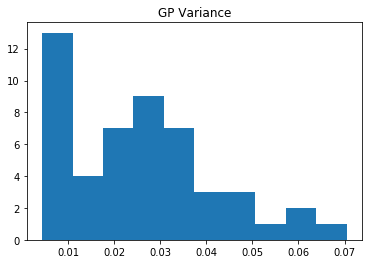

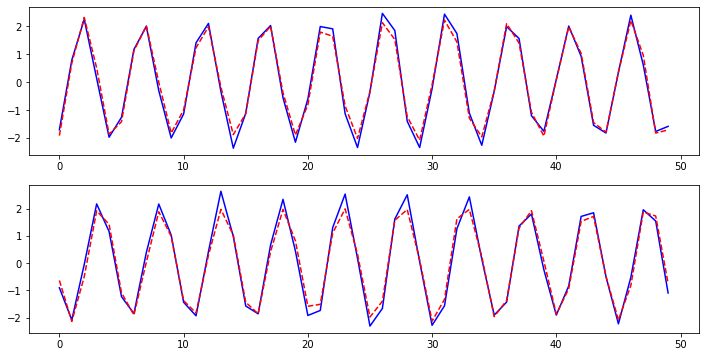

In [326]:
fig0 = plt.figure(0, figsize=(12,8))
if dim == 1:
    ax0 = plt.subplot()
    ax0.plot(Yt[:,0],"b") # states
    ax0.plot(predictions[:,0],'--r')
elif dim == 2:
    ax0 = plt.subplot()
    ax0.plot(Yt[:,0],Yt[:,1],"b") # states
    ax0.plot(predictions[:,0],predictions[:,1],'--r') # map of 1 step ahead predictions
else:
    ax0 = fig0.gca(projection="3d")
    ax0.plot(Yt[:,0],Yt[:,1],Yt[:,2],"b") # states
    ax0.plot(predictions[:,0],predictions[:,1],predictions[:,2],'--r') # map of 1 step ahead predictions
    # ax0.plot(feedForwardPrediction[:,0],feedForwardPrediction[:,1],feedForwardPrediction[:,2],'--g') # map of 50 step ahead prediction

plt.savefig("result-error_vs_actual.png")
    
fig1 = plt.figure(1)
plt.title("1 step error")
plt.hist(diffTable)

mse = sum(diffTable ** 2) / len(diffTable)
print("Mean Squared Error: ",mse)

plt.savefig("result-error_histogram.png")

fig2 = plt.figure(2)
plt.hist(variances)
plt.title("GP Variance")


fig, axIndDims = plt.subplots(dim, figsize = (12,dim*3))

for d in range(dim):
    axIndDims[d].plot(Yt[:,d],"b")
    axIndDims[d].plot(predictions[:,d],"--r")

plt.savefig("result-error_vs_actual_individual_dims.png")

plt.show()

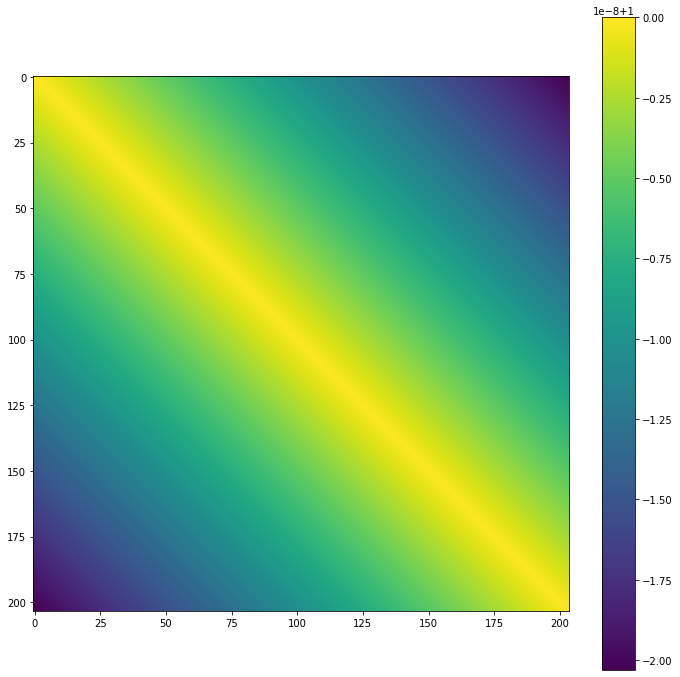

[0.1705 0.8158 0.1623 0.    ]


In [328]:
nDrivers = 1

tau =  gp.hp[1]
phi = gp.hp[2]
aphi = gp.hp[3]

putativeDriverCovarMatrix = np.fromfunction(lambda i,j: 1/np.sqrt(1+2*aphi*abs(i-j)),(X.shape[0],X.shape[0]))
# putativeDriverCovarMatrix = np.fromfunction(lambda i,j: tau*np.exp(-aphi*abs(i-j)**2/2),(X.shape[0],X.shape[0]))
#putativeDriverCovarMatrix = np.fromfunction(lambda i,j: aphi*np.minimum(i,j)/2,(X.shape[0],X.shape[0]))

figDriverCov, axDriverCov = plt.subplots(1,figsize=(12,12))
pltFigDriver = axDriverCov.imshow(putativeDriverCovarMatrix)
plt.colorbar(pltFigDriver)

"""
for i in range(nDrivers):
    axDriverCov[1].plot(rand.multivariate_normal(np.zeros(putativeDriverCovarMatrix.shape[0]),putativeDriverCovarMatrix))
"""

plt.show()
print(gp.hp)

In [ ]:
# This doesn't work in Jupyter lol
fig3 = plt.figure(3)
sliderAx = plt.axes()
slider = Slider(sliderAx,"Tao", 0, 50, valinit=0, valstep=0.1)

fig4 = plt.figure(4)
paramAx = plt.axes()
paramButtons = RadioButtons(paramAx, ("rho","sigma","beta"), active = 0)

def update(val):
    global rho, sigma, beta
    if (paramButtons.value_selected == "rho"):
        rho = slider.val
    elif (paramButtons.value_selected == "sigma"):
        sigma = slider.val
    elif (paramButtons.value_selected == "beta"):
        beta = slider.val

    # Line Plot Update
    s = odeint(LorenzP,t0,t, args=(rho,sigma,beta))
    ax2.clear()
    ax2.plot(s[:,0], s[:,1], s[:,2])

    # Quiver Update
    mi = np.nanmin(s,axis=0)
    ma = np.nanmax(s,axis=0)
    st = abs(mi - ma) / 5
    print(st)

    x, y, z = np.meshgrid(np.arange(mi[0],ma[0],st[0]), np.arange(mi[1],ma[1],st[1]),np.arange(mi[2],ma[2],st[2]))
    u, v, w = (sigma * (y - x), x * (rho - z) - y, x * y - beta * z)
    ax2.quiver(x,y,z,u,v,w,length=5,normalize=True, color = "r", alpha = 0.25)
    
    fig2.canvas.draw()
    fig2.canvas.flush_events()

def update2(val):
    global rho, sigma, beta
    if (paramButtons.value_selected == "rho"):
        slider.set_val(rho)
    elif (paramButtons.value_selected == "sigma"):
        slider.set_val(sigma)
    elif (paramButtons.value_selected == "beta"):
        slider.set_val(beta)

slider.on_changed(update)
paramButtons.on_clicked(update2)

# Quiver Plot
fig2 = plt.figure(2)
ax2 = fig2.gca(projection="3d")


mi = np.nanmin(X,axis=0)
ma = np.nanmax(X,axis=0)
st = abs(mi - ma) / 5
print(st)

x, y, z = np.meshgrid(np.arange(mi[0],ma[0],st[0]), np.arange(mi[1],ma[1],st[1]),np.arange(mi[2],ma[2],st[2]))
u, v, w = (sigma * (y - x), x * (rho - z) - y, x * y - beta * z)
ax2.quiver(x,y,z,u,v,w,length=st[0],normalize=True, color = "r", alpha=0.25)

plt.show()

In [ ]:
print(gp.X)
np.savetxt("trainX.csv", gp.X, delimiter=",",fmt= '%.8f')
np.savetxt("trainY.csv", gp.Y, delimiter=",",fmt= '%.8f')
np.savetxt("testX.csv", Xt, delimiter=",",fmt= '%.8f')
np.savetxt("testY.csv", Yt, delimiter=",",fmt= '%.8f')
